In [ ]:
#import all the required libraries
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve,auc,f1_score, recall_score, precision_score
import keras

# Data pre-processing

In [ ]:
# Load the image data of with_mask from the specified local directory path using opencv library.
# Initialize data and image size
data=[]
path= r'C:\Users\sindh\Desktop\Jupyter Notes\Face mask detection\Dataset-20210506T004102Z-001\Dataset\with_mask'
img_size=224

#Loop over all the images and perform initial pre-processing steps
#The steps include reading the image, convert it to RGB color and resizing the image to 224 * 224 pixels
# Append the pre-processed image and corresponding label to the data list.
for img in os.listdir(path):
    img= os.path.join(path,img)
    pic = cv2.imread(img)
    pic = cv2.cvtColor(pic,cv2.COLOR_BGR2RGB)
    pic = cv2.resize(pic,(img_size,img_size))
    data.append([pic,1])#1 for masked data

In [ ]:
# Load the image data of without_mask from the specified local directory path using opencv library.
path= r'C:\Users\sindh\Desktop\Jupyter Notes\Face mask detection\Dataset-20210506T004102Z-001\Dataset\without_mask'

#Loop over all the images and perform initial pre-processing steps
#The steps include reading the image, convert it to RGB color and resizing the image to 224 * 224 pixels
# Append the pre-processed image and corresponding label to the data list.
for img in os.listdir(path):
    img= os.path.join(path,img)    
    pic = cv2.imread(img)
    pic = cv2.cvtColor(pic,cv2.COLOR_BGR2RGB)
    pic = cv2.resize(pic,(img_size,img_size))
    data.append([pic,0])#0 for unmasked data

In [ ]:
# Display the count of total images read from dataset
print(f'Length of the images: {len(data)}')

Length of the images: 4518


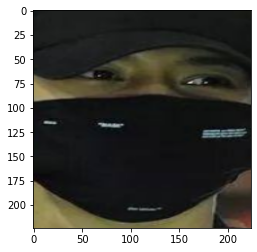

In [ ]:
# Display ths image
plt.imshow(np.array(data[1][0]))

C:\Users\sindh\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

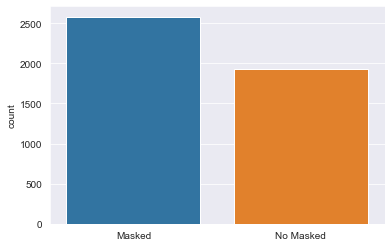

In [ ]:
# Distribution plot of target variable
l = []
for i in data:
    if(i[1] == 0):
        l.append("No Masked")
    else:
        l.append("Masked")
sns.set_style('darkgrid')
sns.countplot(l)

In [ ]:
#Initialize X,y lists to append features, label in data
# Ensure our data is in numpy array format

X=[]
y=[]

for features,label in data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1,224,224,3)
Y= np.array(y)

In [ ]:
#normalize the data
X= X/255.0

In [ ]:
#Split the data into training and testing sets using 80% for training and remanining 20% for testing

trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.20, stratify=Y, random_state=42)

In [ ]:
#Display shape of training data
trainX.shape

(3614, 224, 224, 3)

In [ ]:
#Display shape of testing data
testX.shape

(904, 224, 224, 3)

In [ ]:
# Construct the training image data generator to perform data augumentation

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by standard deviation of the dataset
        samplewise_std_normalization=False,  # divide each input by its standard deviation
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range 
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally 
        height_shift_range=0.1,  # randomly shift images vertically
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

# Modified MobileNetv2 model using transfer learning

In [ ]:
# Initalize the learning rate, number of epochs to train and batchsize
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

#set random seed for uniform results
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(4)

In [ ]:
#Further split of training data into 80% for training and 20% for validation
X_valid, X_train = trainX[:722], trainX[722:]
y_valid, y_train = trainY[:722], trainY[722:]

In [ ]:
#Display shape of training data
X_train.shape

(2892, 224, 224, 3)

In [ ]:
#Display shape of validation data
X_valid.shape

(722, 224, 224, 3)

In [ ]:
#load mobilenetv2 with pre-trained imageNet weights and display model summary
baseModel = MobileNetV2()
baseModel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

# Fine-Tuning

In [ ]:
# Apply transfer learning technique and reuse the bottom layers in the basemodel.
# First layer will be considered as the base_input for model
# Slice out the top 3 layers from base model output as we are going to replace it with fully connected layer

base_input= baseModel.layers[0].input
base_output=baseModel.layers[-4].output

## Add a classification head

In [ ]:
# construct the head of the model and this will be placed on top of the base model

flat_layer= Flatten()(base_output)

# Add dropout layer to avoid overfitting 
dropout_layer = Dropout(0.5)(flat_layer)  

# output layer to perform binary-classification
headModel = Dense(1, activation="sigmoid")(dropout_layer)  

## Freeze the convolution base

In [ ]:
# freeze the base layers of pre-trained model so that weights will not be updated during the process of backpropagation where as head model layers will be tuned

for layer in baseModel.layers:
    layer.trainable = False

In [ ]:
# Actual model used for training after combining both base and head model

model = Model(inputs=base_input, outputs=headModel)

In [ ]:
#summary of modified mobilenetv2 model

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

# Compile and train the model

In [ ]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss= "binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Set early stopping to stop the training if loss starts to increase. It also avoids overfitting
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint("mask_detection_model.h5", save_best_only=True)

# train the model for 20 epochs
history = model.fit(datagen.flow(X_train, y_train, batch_size=BS),
              steps_per_epoch=len(X_train) // BS,
              validation_data=(X_valid, y_valid),
              validation_steps=len(X_valid) // BS,epochs=EPOCHS, callbacks=[early_stopping_cb,checkpoint_cb])

Epoch 1/20
90/90 [==============================] - 87s 920ms/step - loss: 1.3814 - accuracy: 0.8292 - val_loss: 0.1123 - val_accuracy: 0.9834
Epoch 2/20
90/90 [==============================] - 84s 935ms/step - loss: 0.2809 - accuracy: 0.9644 - val_loss: 0.1104 - val_accuracy: 0.9834
Epoch 3/20
90/90 [==============================] - 93s 1s/step - loss: 0.1254 - accuracy: 0.9749 - val_loss: 0.0996 - val_accuracy: 0.9903
Epoch 4/20
90/90 [==============================] - 90s 1s/step - loss: 0.1533 - accuracy: 0.9785 - val_loss: 0.1100 - val_accuracy: 0.9889
Epoch 5/20
90/90 [==============================] - 92s 1s/step - loss: 0.2054 - accuracy: 0.9785 - val_loss: 0.0903 - val_accuracy: 0.9931
Epoch 6/20
90/90 [==============================] - 90s 1000ms/step - loss: 0.2119 - accuracy: 0.9760 - val_loss: 0.1369 - val_accuracy: 0.9917
Epoch 7/20
90/90 [==============================] - 88s 975ms/step - loss: 0.1119 - accuracy: 0.9864 - val_loss: 0.1399 - val_accuracy: 0.9889
Epoch 8

# Learning curves

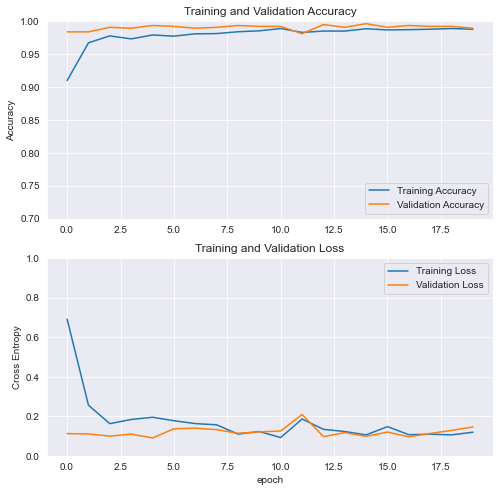

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim(0.7,1) #[min(plt.ylim())
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Model Evaluation and Predictions

In [ ]:
# Evaluate model on test data
model.evaluate(testX,testY)

29/29 [==============================] - 18s 632ms/step - loss: 0.1463 - accuracy: 0.9900


[0.14630964398384094, 0.9900442361831665]

In [ ]:
# Load the saved model 
saved_model = keras.models.load_model("mask_detection_model.h5")

## Classification report

In [ ]:
pred_final=(saved_model.predict(testX) > 0.5).astype("int32")

#classification report of actual and predicted data
print(classification_report(testY,pred_final,target_names=['Without mask (Class 0)','With mask (Class 1)']))

                        precision    recall  f1-score   support

Without mask (Class 0)       0.99      0.99      0.99       387
   With mask (Class 1)       0.99      0.99      0.99       517

              accuracy                           0.99       904
             macro avg       0.99      0.99      0.99       904
          weighted avg       0.99      0.99      0.99       904



In [ ]:
print("Accuracy:", accuracy_score(testY,pred_final))
print("F1 Score:", f1_score(testY,pred_final))
print("Precision:", precision_score(testY,pred_final))
print("Recall:", recall_score(testY,pred_final))

Accuracy: 0.9922566371681416
F1 Score: 0.9932367149758454
Precision: 0.9922779922779923
Recall: 0.9941972920696325


## Confusion matrix

In [ ]:
#confusion matrix on actual and predicted data

cf_matrix=confusion_matrix(testY,pred_final)

Text(0.5, 1.0, 'Confusion matrix for improved MobileNetV2')

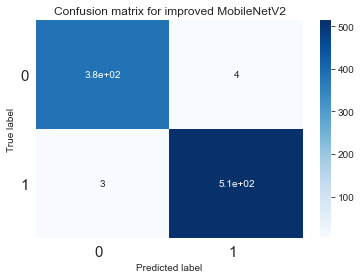

In [ ]:
heatmap= sns.heatmap(cf_matrix, annot=True, cmap='Blues')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for improved MobileNetV2')

## ROC curve

In [ ]:
#plot roc curve

y_pred = pred_final.ravel()
fpr, tpr, thresholds = roc_curve(testY, y_pred)

In [ ]:
auc_score= auc(fpr, tpr)

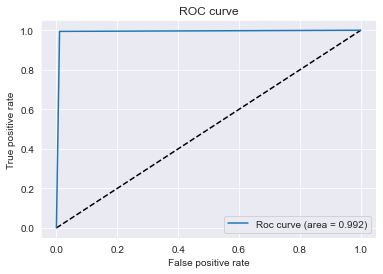

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Roc curve (area = {:.3f})'.format(auc_score))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Visualization of correct and incorrect predictions on test data




In [ ]:
correct_data=[]
correct_datalabel=[]
missclass_data=[]
missclass_datalabel=[]
for i in range(len(testY)):
    if testY[i]==pred_final[i]:
        correct_data.append(testX[i])
        correct_datalabel.append(pred_final[i])
    else:
        missclass_data.append(testX[i])
        missclass_datalabel.append(pred_final[i])

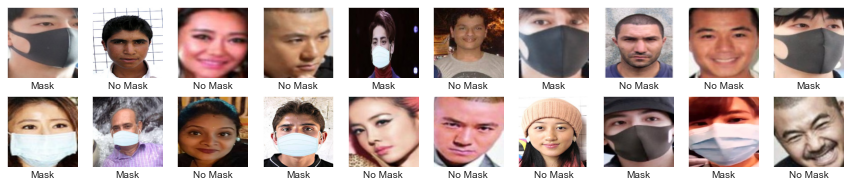

In [ ]:
plt.figure(figsize=(15, 3))

for i in range(20):
    l1_plot = plt.subplot(2, 10, i + 1)
    l1_plot.imshow(correct_data[i], cmap=plt.cm.gray_r)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    if correct_datalabel[i]==0:
        label='No Mask' 
    else: 
        label='Mask'
    l1_plot.set_xlabel(label)

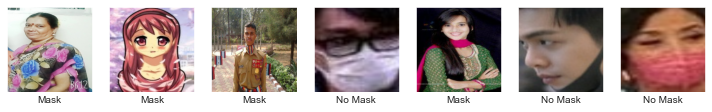

In [ ]:
plt.figure(figsize=(18, 4))

for i in range(7):
    l1_plot = plt.subplot(2, 10, i + 1)
    l1_plot.imshow(missclass_data[i], cmap=plt.cm.gray_r)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    if missclass_datalabel[i]==0:
      label='No Mask' 
    else: 
      label='Mask'
    l1_plot.set_xlabel(label)

## Testing on unseen images

In [ ]:
# Function to predict new image
def predict_class(img_name, model):
    test_image = cv2.imread(img_name)
    plt.imshow(cv2.cvtColor(test_image,cv2.COLOR_BGR2RGB))
    test_image = cv2.resize(test_image,(224,224))
    test_image=np.expand_dims(test_image, axis=0)
    test_image=test_image/255.0
    result = model.predict(test_image)
    if (result)> 0.5:  
         print("Predicted : With mask") 
    else: 
        print("Predicted : Without Mask")

Predicted : With mask


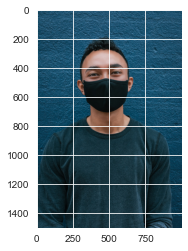

In [ ]:
predict_class("Unseen_images/photo-1598207951491-255eaf139751.jpg", saved_model)

Predicted : With mask


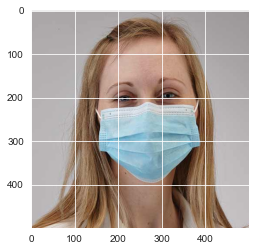

In [ ]:
predict_class("Unseen_images/e54209915-disposable-face-mask-usage.jpg", model)

Predicted : With mask


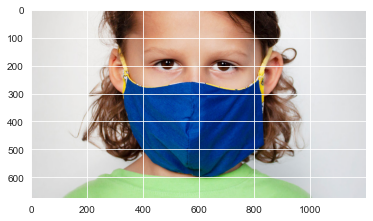

In [ ]:
predict_class("Unseen_images/banner-kidswearmasks.jpg", model)

Predicted : Without Mask


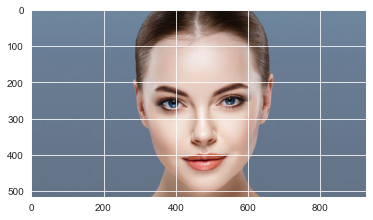

In [ ]:
predict_class("Unseen_images/1493458748-beauty-face-517.jpg", model)

Predicted : With mask


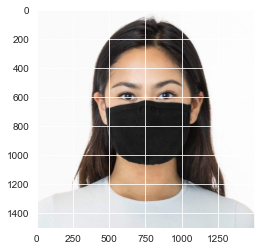

In [ ]:
predict_class("Unseen_images/test2.jpg", model)